### Imports

In [2]:
import os
import sys
import warnings
from pathlib import Path
import time

# import threading
# import multiprocessing
import concurrent.futures

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# import requests
# from bs4 import BeautifulSoup

CURRENT_DIR = Path(os.getcwd())

# Move to the root directory

ROOT_DIR = CURRENT_DIR.parents[0]  # Adjust the number based on your folder structure

RAW_FILE_PATH = ROOT_DIR / "wavelength_spectra_files"
RAW_FILE_PATH.mkdir(parents=True, exist_ok=True)
EXPORTS_FILE_PATH = ROOT_DIR / "exports"
EXPORTS_FILE_PATH.mkdir(parents=True, exist_ok=True)

# Add the root directory to the system path

sys.path.append(str(ROOT_DIR))

# Input Raw File and Decoder File

In [3]:
wafer_codes = [
    "QCHZZ",
]  # List of wafer codes

warnings.filterwarnings("ignore")

ANALYSIS_RUN_NAME = "complete"


def find_files_with_wafer_codes(wafer_codes, raw_file_path):
    # Initialize an empty list to store the paths of the files
    file_paths = []

    # Iterate over each wafer code in the list
    for code in wafer_codes:
        # Iterate over each file in the raw file path directory
        for root, dirs, files in os.walk(raw_file_path):
            for file in files:
                # Check if the wafer code is in the file name
                if code in file:
                    # Add the full path of the file to the list
                    file_paths.append(Path(root) / file)

    return file_paths


# Call the function and print the results
file_paths = find_files_with_wafer_codes(wafer_codes, RAW_FILE_PATH)
print(file_paths)

[WindowsPath('c:/Users/762093/OneDrive - Seagate Technology/Documents/LIV/vadankhan-wavelength-spectra-analyser/wavelength_spectra_files/QCHZZ_spectra.csv')]


# Transform Data

In [4]:
def transform_raw_file(filepath, wafer_id, wavelength_lb=824, wavelength_ub=830, chunksize=1000, max_chunks=1000):
    col_names = pd.read_csv(filepath, nrows=1).columns  # Read just headers
    intensity_cols = [col for col in col_names if col.startswith("Intensity_")]

    # Extract wavelengths from column names
    wavelengths = {col: float(col.split("_")[1]) for col in intensity_cols}

    # Filter columns to only include those between 825 and 835
    selected_intensity_cols = [col for col, wl in wavelengths.items() if wavelength_lb <= wl <= wavelength_ub]

    # Define columns to read
    usecols = ["X", "Y"] + selected_intensity_cols

    with pd.read_csv(filepath, chunksize=chunksize, usecols=usecols) as reader:
        for i, chunk in enumerate(reader):
            if i >= max_chunks:
                break  # Stop after processing max_chunks

            # start_time = time.time()  # Start timing

            # Melt the dataframe: Convert wide format to long format
            long_df = chunk.melt(id_vars=["X", "Y"], value_vars=selected_intensity_cols, var_name="Wavelength", value_name="Intensity")

            # Convert "Wavelength" column from "Intensity_xxx" to just "xxx"
            long_df["Wavelength"] = long_df["Wavelength"].map(wavelengths)

            # end_time = time.time()  # End timing
            # processing_time = end_time - start_time
            # print(f"Chunk {i+1}/{max_chunks} processed. Time taken: {processing_time:.2f} seconds.")

            yield long_df  # Yield processed chunk instead of storing in memory


def process_and_export(filepath, wafer_code):
    output_path = EXPORTS_FILE_PATH / f"{ANALYSIS_RUN_NAME}_{wafer_code}_spectra_formatted.csv"
    first_chunk = True

    for transformed_chunk in transform_raw_file(filepath, wafer_code):
        # # Sort chunk before writing
        # sort_start_time = time.time()
        # transformed_chunk = transformed_chunk.sort_values(by=["X", "Y"])
        # sort_end_time = time.time()
        # sort_time = sort_end_time - sort_start_time
        # print(f"Sorting completed for chunk. Time taken: {sort_time:.2f} seconds.")

        # Export chunk-by-chunk
        # export_start_time = time.time()
        transformed_chunk.to_csv(output_path, mode="w" if first_chunk else "a", header=first_chunk, index=False)
        # export_end_time = time.time()
        # export_time = export_end_time - export_start_time
        # print(f"Chunk exported. Time taken: {export_time:.2f} seconds.")

        first_chunk = False  # Only write header for the first chunk


transformed_files = []

# warnings.filterwarnings("ignore")

# CALLING THE CODE
start_total_time = time.time()
print("\n=== Starting full processing run ===\n")
for filepath, wafer_code in zip(file_paths, wafer_codes):
    process_and_export(filepath, wafer_code)
    transformed_files.append(filepath)
end_total_time = time.time()
total_time = end_total_time - start_total_time
print(f"\n=== Total processing time: {total_time:.2f} seconds ===\n")


# transformed_files.append(transformed_file)


=== Starting full processing run ===


=== Total processing time: 110.08 seconds ===



### Threading Attempt

In [12]:
ANALYSIS_RUN_NAME = "larger"

RAW_FILE_PATH = ROOT_DIR / "wavelength_spectra_files"
EXPORTS_FILE_PATH = ROOT_DIR / "exports"


def transform_raw_file(filepath, wafer_id, wavelength_lb=827, wavelength_ub=830, chunksize=1000, max_chunks=1000):
    col_names = pd.read_csv(filepath, nrows=1).columns  # Read just headers
    intensity_cols = [col for col in col_names if col.startswith("Intensity_")]

    # Extract wavelengths from column names
    wavelengths = {col: float(col.split("_")[1]) for col in intensity_cols}

    # Filter columns to only include those within the desired range
    selected_intensity_cols = [col for col, wl in wavelengths.items() if wavelength_lb <= wl <= wavelength_ub]

    # Define columns to read
    usecols = ["X", "Y"] + selected_intensity_cols

    with pd.read_csv(filepath, chunksize=chunksize, usecols=usecols) as reader:
        for i, chunk in enumerate(reader):
            if i >= max_chunks:
                break  # Stop after processing max_chunks

            # Melt the dataframe: Convert wide format to long format
            long_df = chunk.melt(id_vars=["X", "Y"], value_vars=selected_intensity_cols, var_name="Wavelength", value_name="Intensity")

            # Convert "Wavelength" column from "Intensity_xxx" to just "xxx"
            long_df["Wavelength"] = long_df["Wavelength"].map(wavelengths)

            yield long_df  # Yield processed chunk instead of storing in memory


def process_and_export(filepath, wafer_code, export_path, run_name):
    try:
        print(f"Processing file: {filepath} for wafer: {wafer_code}")
        output_path = export_path / f"{run_name}_threaded_{wafer_code}_spectra_formatted.csv"
        first_chunk = True

        for transformed_chunk in transform_raw_file(filepath, wafer_code):
            # export_start_time = time.time()
            transformed_chunk.to_csv(output_path, mode="w" if first_chunk else "a", header=first_chunk, index=False)
            first_chunk = False  # Only write header for the first chunk
            # print(f"Chunk exported for wafer {wafer_code}. Time taken: {time.time() - export_start_time:.2f} seconds.")
    except Exception as e:
        print(f"Error processing wafer {wafer_code}: {e}")


def parallel_processing(filepaths, wafer_codes, export_path, run_name):
    print(f"Starting parallel processing with {len(filepaths)} files.")
    # Use ThreadPoolExecutor instead of ProcessPoolExecutor
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_and_export, f, w, export_path, run_name): (f, w) for f, w in zip(filepaths, wafer_codes)}
        for future in concurrent.futures.as_completed(futures):
            filepath, wafer_code = futures[future]
            try:
                future.result()  # This will raise any exception raised in the process
            except Exception as e:
                print(f"Error with file {filepath}, wafer {wafer_code}: {e}")


# CALLING THE CODE
if __name__ == "__main__":
    start_total_time = time.time()
    print("\n=== Starting full processing run with multiprocessing ===\n")
    parallel_processing(file_paths, wafer_codes, EXPORTS_FILE_PATH, ANALYSIS_RUN_NAME)
    end_total_time = time.time()
    total_time = end_total_time - start_total_time
    print(f"\n=== Total processing time: {total_time:.2f} seconds ===\n")


=== Starting full processing run with multiprocessing ===

Starting parallel processing with 1 files.
Processing file: c:\Users\762093\OneDrive - Seagate Technology\Documents\LIV\vadankhan-wavelength-spectra-analyser\wavelength_spectra_files\QCHZZ_spectra.csv for wafer: QCHZZ

=== Total processing time: 50.94 seconds ===



# Spectrum Plotting

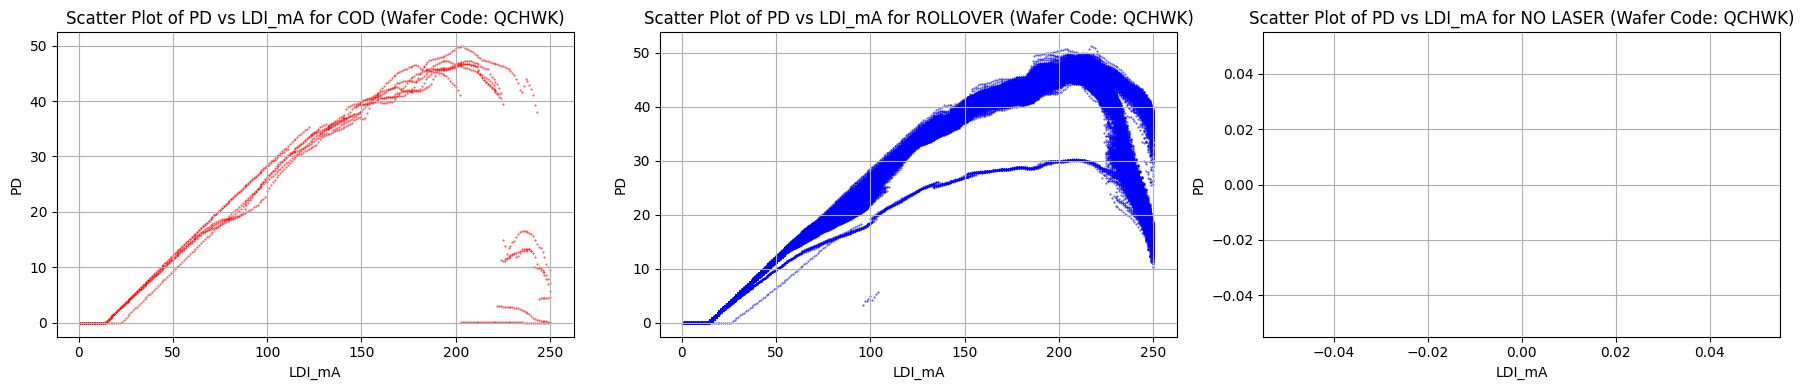

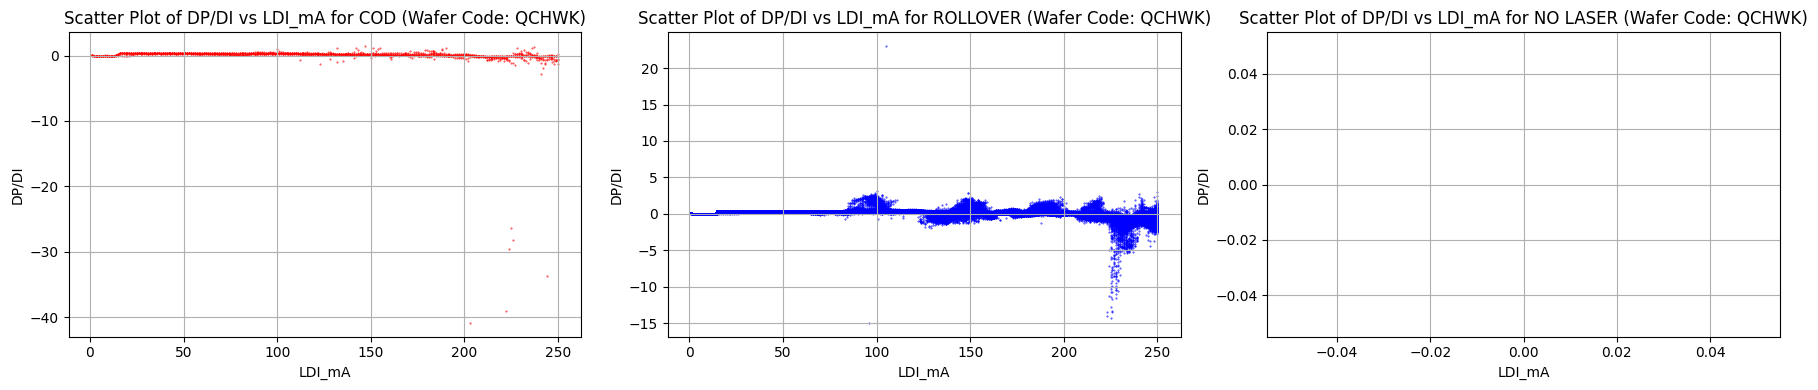

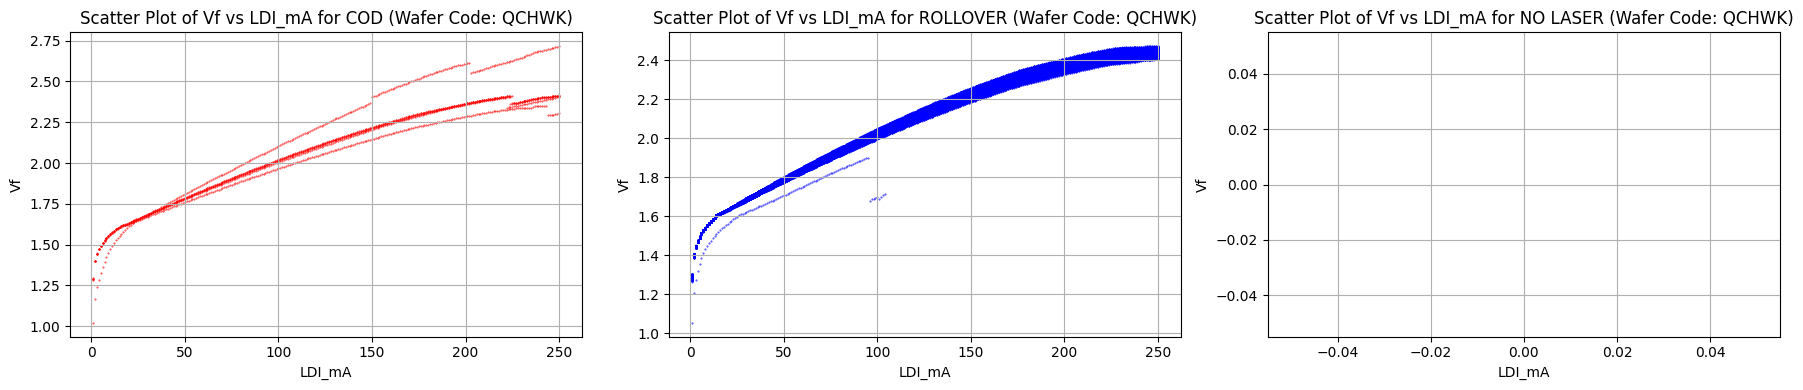

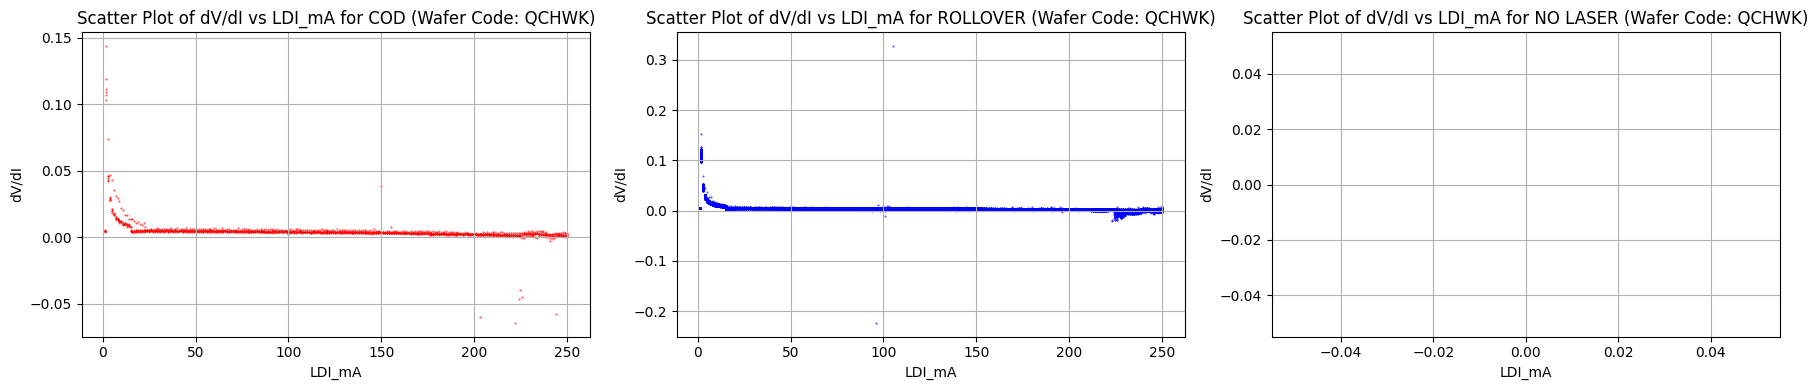

In [24]:
def plot_sweep_data(df_raw_sweeps, wafer_code):
    cod_roll_eval_types = ["COD", "ROLLOVER", "NO LASER"]
    colors = ["red", "blue", "orange"]

    # Scatter plot of PD against LDI_mA with subplots for each COD_ROLL_EVAL type
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    for ax, cod_type, color in zip(axs, cod_roll_eval_types, colors):
        group = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == cod_type]
        ax.scatter(group["LDI_mA"], group["PD"], alpha=0.8, s=0.2, color=color)
        ax.set_title(f"Scatter Plot of PD vs LDI_mA for {cod_type} (Wafer Code: {wafer_code})")
        ax.set_xlabel("LDI_mA")
        ax.set_ylabel("PD")
        ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot DP/DI against LDI_mA with subplots for each COD_ROLL_EVAL type
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    for ax, cod_type, color in zip(axs, cod_roll_eval_types, colors):
        group = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == cod_type]
        ax.scatter(group["LDI_mA"], group["DP/DI"], alpha=0.8, s=0.2, color=color)
        ax.set_title(f"Scatter Plot of DP/DI vs LDI_mA for {cod_type} (Wafer Code: {wafer_code})")
        ax.set_xlabel("LDI_mA")
        ax.set_ylabel("DP/DI")
        ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Scatter plot of Vf against LDI_mA with subplots for each COD_ROLL_EVAL type
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    for ax, cod_type, color in zip(axs, cod_roll_eval_types, colors):
        group = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == cod_type]
        ax.scatter(group["LDI_mA"], group["Vf"], alpha=0.8, s=0.2, color=color)
        ax.set_title(f"Scatter Plot of Vf vs LDI_mA for {cod_type} (Wafer Code: {wafer_code})")
        ax.set_xlabel("LDI_mA")
        ax.set_ylabel("Vf")
        ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot dV/dI against LDI_mA with subplots for each COD_ROLL_EVAL type
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    for ax, cod_type, color in zip(axs, cod_roll_eval_types, colors):
        group = df_raw_sweeps[df_raw_sweeps["COD_ROLL_EVAL"] == cod_type]
        ax.scatter(group["LDI_mA"], group["dV/dI"], alpha=0.8, s=0.2, color=color)
        ax.set_title(f"Scatter Plot of dV/dI vs LDI_mA for {cod_type} (Wafer Code: {wafer_code})")
        ax.set_xlabel("LDI_mA")
        ax.set_ylabel("dV/dI")
        ax.grid(True)
    plt.tight_layout()
    plt.show()


# Calling Code
for df_raw_sweeps in annotated_sweeps_tables:
    wafer_code = df_raw_sweeps["WAFER_ID"].iloc[0]
    plot_sweep_data(df_raw_sweeps, wafer_code)